In [1]:
'''Train CIFAR10 with PyTorch.'''
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import CosineAnnealingLR

from onecycle import CustomOneCycleLR

import torchvision
import torchvision.transforms as transforms
from pytorch_lamb import Lamb
import os
import argparse
import csv

import models

#from utils import progress_bar, mixup_data, mixup_criterion
from utils import mixup_data, mixup_criterion

import numpy
import random

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

print(model_names)

print(torch.__version__)

['dpn26', 'dpn92', 'fixup_resnet110', 'fixup_resnet1202', 'fixup_resnet20', 'fixup_resnet32', 'fixup_resnet44', 'fixup_resnet56', 'nobn_rezero_resnet56', 'preact_resnet101', 'preact_resnet101_rezero', 'preact_resnet152', 'preact_resnet152_rezero', 'preact_resnet18', 'preact_resnet18_rezero', 'preact_resnet34', 'preact_resnet34_rezero', 'preact_resnet50', 'preact_resnet50_rezero', 'resnet110', 'resnet1202', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet_v110', 'resnet_v1202', 'resnet_v20', 'resnet_v32', 'resnet_v44', 'resnet_v56', 'rezero_dpn26', 'rezero_dpn92', 'rezero_preactresnet101', 'rezero_preactresnet152', 'rezero_preactresnet18', 'rezero_preactresnet34', 'rezero_preactresnet50', 'rezero_resnet110', 'rezero_resnet1202', 'rezero_resnet20', 'rezero_resnet32', 'rezero_resnet44', 'rezero_resnet56', 'rezero_resnet602']
1.4.0


In [2]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('-a', '--arch', metavar='ARCH', default='rezero_preactresnet18', choices=model_names, help='model architecture: ' +
                        ' | '.join(model_names) + ' (default: fixup_resnet110)')
parser.add_argument('--sess', default='superc', type=str, help='session id')
parser.add_argument('--seed', default=random.randint(0,10000), type=int, help='rng seed')
parser.add_argument('--decay', default=2e-4, type=float, help='weight decay (default=2e-4)')
parser.add_argument('--batchsize', default=512, type=int, help='batch size per GPU (default=512)')
parser.add_argument('--n_epoch', default=40, type=int, help='total number of epochs')
parser.add_argument('--init_lr', default=0.1, type=float)
parser.add_argument('--point_1_step', default = 0.145, type=float)
parser.add_argument('--point_1_lr', default = 1., type=float)
parser.add_argument('--point_2_step', default = 0.78, type=float)
parser.add_argument('--point_2_lr', default = 0.048, type=float)
parser.add_argument('--end_lr', default=0.001, type=float)
parser.add_argument('--resweight_lr', default=0.1, type=float)
parser.add_argument('--momentum_range', default=(0.85, 0.95), type=tuple)
parser.add_argument('--exp_decay', default=False, type=bool)
parser.add_argument('--progress_bar', default='True', type=str, help='display progress bar')





args_input = [
   '-a', 'rezero_preactresnet18',
    '--sess', 'superc', 
    '--batchsize','512',
    '--progress_bar', 'False',
    '--init_lr', '.048',
    '--point_1_lr', '.8',
    '--point_1_step', '0.145',
    '--point_2_lr', '0.048',
    '--point_2_step', '0.9',
    '--n_epoch', '45',
    '--decay', '2e-4',
    '--resweight_lr', '0.1'
]

global arg
args = parser.parse_args(args_input); args
args.progress_bar = (args.progress_bar=='True')
if args.progress_bar:
    from utils import progress_bar
    
    

torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
numpy.random.seed(args.seed)
random.seed(args.seed)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = args.batchsize
lr = args.init_lr



# Data
print('==> Preparing data..')
normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
scale_size = 40
size=32
padding = int((scale_size - size) / 2)
transform_train = transforms.Compose([
        transforms.RandomCrop(size, padding=4),
        transforms.ColorJitter(.25,.25,.25),
        transforms.RandomRotation(2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# Model
net = models.__dict__[args.arch]()

result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

logname = result_folder + args.arch + '_' + args.sess + '_' + str(args.seed) + '.csv'

if use_cuda:
    net.cuda()
    #net = torch.nn.DataParallel(net)
    print('Using', torch.cuda.device_count(), 'GPUs.')
    cudnn.benchmark = True
    print('Using CUDA..')
    
#Training
criterion = nn.CrossEntropyLoss().cuda()


parameters_others = [p[1] for p in net.named_parameters() if not ('resweight' in p[0])]
parameters_resweight = [p[1] for p in net.named_parameters() if 'resweight' in p[0]]




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#lr_finder = LRFinder(net, optimizer, criterion, device)
#lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
#lr_finder.plot()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Using 1 GPUs.
Using CUDA..


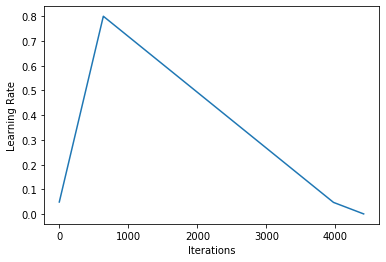

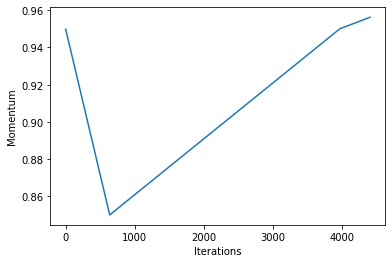

In [3]:
#scheduler = OneCycleLR(optimizer, lr_range = (1/25.* args.base_lr,args.base_lr),
#                       num_steps = args.n_epoch * len(trainloader), annihilation_frac =.22,
#                       reduce_factor = 0.01)


num_steps = args.n_epoch * len(trainloader)
init_lr = args.init_lr
point_1 = (args.point_1_step,args.point_1_lr)
point_2 = (args.point_2_step,args.point_2_lr)
end_lr = args.end_lr
momentum_range = args.momentum_range
exp_decay = args.exp_decay
param_group = 0
resweight_lr = args.resweight_lr


optimizer = Lamb([
        {'params': parameters_others, 'lr': 0.01}],weight_decay = args.decay)
optimizer_resweight = optim.Adagrad([
        {'params': parameters_resweight, 'lr': resweight_lr}])





scheduler = CustomOneCycleLR(optimizer, 
                             num_steps = num_steps,
                             init_lr = init_lr,
                             point_1 = point_1,
                             point_2 = point_2,
                             end_lr = end_lr,
                             momentum_range = momentum_range,
                             exp_decay = exp_decay,
                             param_group = param_group)


scheduler.test_plt()


# Training
def train(epoch):
    #print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        outputs = net(inputs)
        optimizer.zero_grad()
        optimizer_resweight.zero_grad()
        loss = criterion( outputs,targets )
        loss.backward()
        optimizer.step()
        optimizer_resweight.step()
        scheduler.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (torch.sum(predicted == targets.data)).cpu()
        
        acc = (100.*float(correct)/float(total))
        if args.progress_bar:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (train_loss/(batch_idx+1), acc, correct, total))

    return (train_loss/batch_idx, acc)

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion( outputs,targets )

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            if args.progress_bar:
                progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                    % (test_loss/(batch_idx+1), 100.*float(correct)/float(total), correct, total))

        # Save checkpoint.
        acc = 100.*float(correct)/float(total)
        if acc > best_acc:
            best_acc = acc
            checkpoint(acc, epoch)

    return (test_loss/batch_idx, acc)

def checkpoint(acc, epoch):
    # Save checkpoint.
    #print('Saving..')
    state = {
        'net': net,
        'acc': acc,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + args.arch + '_' + args.sess + '_' + str(args.seed) + '.ckpt')


if not os.path.exists(logname):
    with open(logname[:-4]+'_args.csv', 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['filename = '+logname,'arch = ' +args.arch, 'batchsize = '+str(args.batchsize), 'decay = '+ str(args.decay),
                          'n_epoch = ' +str(args.n_epoch),  'seed = '+str(args.seed) , 'sess = '+args.sess,
                           'num_steps = ' + str(num_steps),
                            ' init_lr = ' + str (init_lr),
                             ' point_1 = ' + str ( point_1),
                             ' point_2 = ' + str ( point_2),
                             ' end_lr = ' + str ( end_lr),
                             ' momentum_range = ' + str ( momentum_range),
                             ' exp_decay = ' + str ( exp_decay),
                             ' param_group = ' + str ( param_group),
                             ' resweight_lr = ' + str (resweight_lr)])
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'lr', 'train loss', 'train acc', 'test loss', 'test acc'])

def print_resweights(epoch = 0):
    resweights = '|' + str(epoch) + ' resweights: ['
    for p in parameters_resweight:
        resweights += "{:1.2f}, ".format(p[0])
    resweights = resweights[:-2]+']'
    print(resweights)

In [4]:
best = 0

for epoch in range(start_epoch, args.n_epoch):
    lr = optimizer.param_groups[0]['lr']
    print_resweights(epoch)
    epoch_time = time.time()
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    epoch_time = time.time() - epoch_time
    if best<test_acc:
        best = test_acc
    print('|{:2d}: |{:2.0f}s |'
          'lr {:02.4f} | '
          'train loss {:1.3f} |train acc {:2.2f}%|'
          'test loss {:1.3f} |test acc {:2.2f}% (best: {:2.2f}%)'.format(
            epoch,epoch_time,  lr,
            train_loss, train_acc, test_loss, test_acc,best))
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, lr, train_loss, train_acc, test_loss, test_acc])


|0 resweights: [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
| 0: |48s |lr 0.0480 | train loss 2.104 |train acc 23.91%|test loss 3.635 |test acc 12.46% (best: 12.46%)
|1 resweights: [0.01, 0.01, -0.19, -0.01, -0.72, -0.32, -0.02, -0.00]
| 1: |43s |lr 0.1633 | train loss 4.761 |train acc 10.37%|test loss 90.066 |test acc 11.45% (best: 12.46%)
|2 resweights: [-0.05, -0.09, -0.19, -0.03, -0.58, -0.58, 0.01, -0.00]


KeyboardInterrupt: 

In [ ]:
print(optimizer)

In [ ]:
def print_resweights():
    resweights = 'resweights: ['
    for p in parameters_resweight:
        resweights += "{:1.1f}, ".format(p[0])
    resweights = resweights[:-2]+']'
    print(resweights)

In [ ]:
print(optimizer)

In [ ]:
print_resweights()